# Group 10
- Hung-Yang Chang 260899468
- Alexander Fernandes 260960205

In [ ]:
import torch

# Check if using GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(f"Nvidia Cuda/GPU is available!")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Nvidia Cuda/GPU is available!
Wed Mar 31 02:23:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                          

In [ ]:
# Import relevant modules
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np
import random 
import time
import math


import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


# Load Data

In [ ]:
# p(mbar), atmospheric pressure
# T (degC), air temperature
# rh (%), relative humidity
# wv(m/s), wind velocity

import pandas as pd
train_url = "https://raw.githubusercontent.com/HungYangChang/ECSE552_weather-forecasting/main/weather_train.csv"
test_url = "https://raw.githubusercontent.com/HungYangChang/ECSE552_weather-forecasting/main/weather_test.csv"

weather_train = pd.read_csv(train_url)
weather_test = pd.read_csv(test_url)

date_time_train = pd.to_datetime(weather_train.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
date_time_test = pd.to_datetime(weather_test.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')



In [ ]:
print(weather_train.head())
print (weather_train.shape)

weather_train.describe().transpose()

   p (mbar)  T (degC)  Tpot (K)  ...  wv (m/s)  max. wv (m/s)  wd (deg)
0    996.50     -8.05    265.38  ...      0.21           0.63     192.7
1    996.62     -8.88    264.54  ...      0.25           0.63     190.3
2    996.84     -8.81    264.59  ...      0.18           0.63     167.2
3    996.99     -9.05    264.34  ...      0.10           0.38     240.0
4    997.46     -9.63    263.72  ...      0.40           0.88     157.0

[5 rows x 14 columns]
(56072, 14)


,count,mean,std,min,25%,50%,75%,max
p (mbar),56072.0,988.832928,8.350194,913.60,983.8100,989.240,994.3100,1013.91
T (degC),56072.0,8.987746,8.440986,-22.76,2.8800,8.970,15.0700,35.65
Tpot (K),56072.0,283.059875,8.518036,250.85,277.0000,283.100,289.1300,309.73
Tdew (degC),56072.0,4.551409,6.830787,-24.80,-0.1200,4.745,9.7325,23.06
rh (%),56072.0,76.208224,16.498261,13.88,65.4975,79.500,89.6000,100.00
VPmax (mbar),56072.0,13.170791,7.479040,0.97,7.5200,11.470,17.1600,58.34
VPact (mbar),56072.0,9.297106,4.150333,0.81,6.0500,8.575,12.0800,28.25
VPdef (mbar),56072.0,3.873606,4.673326,0.00,0.8200,2.090,5.1000,41.78
sh (g/kg),56072.0,5.874655,2.634644,0.51,3.8200,5.410,7.6300,18.07
H2OC (mmol/mol),56072.0,9.404474,4.201705,0.81,6.1200,8.680,12.2100,28.74


In [ ]:
print(weather_test.head())
print (weather_test.shape)

weather_test.describe().transpose()

   p (mbar)  T (degC)  Tpot (K)  ...  wv (m/s)  max. wv (m/s)  wd (deg)
0    990.00     17.93    291.93  ...      1.58           2.16     34.37
1    989.86     16.92    290.93  ...      0.23           0.60     20.89
2    990.11     15.82    289.80  ...      0.26           0.52    252.00
3    990.01     15.02    289.01  ...      1.22           1.88    218.50
4    989.89     14.14    288.14  ...      1.43           1.96    218.00

[5 rows x 14 columns]
(14019, 14)


,count,mean,std,min,25%,50%,75%,max
p (mbar),14019.0,990.732392,8.220120,956.96,985.910,990.96,995.960,1015.29
T (degC),14019.0,11.301290,8.092519,-13.67,5.080,11.07,17.040,37.28
Tpot (K),14019.0,285.225804,8.224984,259.15,279.100,284.95,291.030,311.21
Tdew (degC),14019.0,6.576604,6.045940,-15.30,2.030,6.80,11.350,19.78
rh (%),14019.0,75.216103,16.357764,23.64,64.250,78.30,88.800,99.90
VPmax (mbar),14019.0,15.199599,8.514445,2.12,8.775,13.20,19.460,63.77
VPact (mbar),14019.0,10.481350,4.182481,1.85,7.080,9.89,13.450,23.10
VPdef (mbar),14019.0,4.718212,5.661257,0.01,1.090,2.60,6.070,46.01
sh (g/kg),14019.0,6.614139,2.657874,1.15,4.450,6.23,8.490,14.76
H2OC (mmol/mol),14019.0,10.584220,4.235651,1.84,7.130,9.98,13.570,23.51


# Data pre-processing

## Clean up test data

In [ ]:
wv = weather_test.loc[:, ['wv (m/s)']]
wv_correct = weather_test['wv (m/s)'] < 0
wv[wv_correct]  = 0

maxwv = weather_test.loc[:, ['max. wv (m/s)']]
maxwv_correct = weather_test['max. wv (m/s)'] < 0
maxwv[maxwv_correct] = 0

weather_test['wv (m/s)'] = wv
weather_test['max. wv (m/s)'] = maxwv

In [ ]:
weather_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),14019.0,990.732392,8.220120,956.96,985.910,990.96,995.960,1015.29
T (degC),14019.0,11.301290,8.092519,-13.67,5.080,11.07,17.040,37.28
Tpot (K),14019.0,285.225804,8.224984,259.15,279.100,284.95,291.030,311.21
Tdew (degC),14019.0,6.576604,6.045940,-15.30,2.030,6.80,11.350,19.78
rh (%),14019.0,75.216103,16.357764,23.64,64.250,78.30,88.800,99.90
VPmax (mbar),14019.0,15.199599,8.514445,2.12,8.775,13.20,19.460,63.77
VPact (mbar),14019.0,10.481350,4.182481,1.85,7.080,9.89,13.450,23.10
VPdef (mbar),14019.0,4.718212,5.661257,0.01,1.090,2.60,6.070,46.01
sh (g/kg),14019.0,6.614139,2.657874,1.15,4.450,6.23,8.490,14.76
H2OC (mmol/mol),14019.0,10.584220,4.235651,1.84,7.130,9.98,13.570,23.51


## normalization

In [ ]:
# pre-processing: normalization
# normalization
weather_train_mean = weather_train.mean()
weather_train_std = weather_train.std()

train_df = (weather_train - weather_train_mean) / weather_train_std
test_df = (weather_test - weather_train_mean) / weather_train_std

# after normalization
train_df.describe().transpose()
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),14019.0,0.227476,0.984423,-3.817029,-0.350043,0.254733,0.853522,3.168438
T (degC),14019.0,0.274085,0.958717,-2.684254,-0.462949,0.246684,0.953947,3.351771
Tpot (K),14019.0,0.254276,0.965596,-2.806970,-0.464881,0.221897,0.935676,3.304767
Tdew (degC),14019.0,0.296480,0.885102,-2.906167,-0.369124,0.329185,0.995287,2.229405
rh (%),14019.0,-0.060135,0.991484,-3.186289,-0.724817,0.126788,0.763218,1.436017
VPmax (mbar),14019.0,0.271266,1.138441,-1.477568,-0.587748,0.003905,0.840911,6.765468
VPact (mbar),14019.0,0.285337,1.007746,-1.794339,-0.534200,0.142855,1.000617,3.325732
VPdef (mbar),14019.0,0.180729,1.211398,-0.826736,-0.595637,-0.272527,0.469985,9.016361
sh (g/kg),14019.0,0.280677,1.008817,-1.793280,-0.540739,0.134874,0.992675,3.372503
H2OC (mmol/mol),14019.0,0.280778,1.008079,-1.800334,-0.541322,0.136974,0.991389,3.357096


## Feature Visualization

Fourier Transform

With the FFT we will be able to observe any underlying periodic nature from the feature.

Many features correspond to 1 year or 1 day periodicity.

We may be interested in using features that have high 1-day or 24-hour periodicity.

List of features with a distinct 1 day frequency peaks
 - T (degC)
 - Tpot (K)
 - rh (%)
 - VPmax (mbar)
 - VPdef (mbar)
 - rho (g/m**3)
 - wv (m/s)
 - wd (m/s)

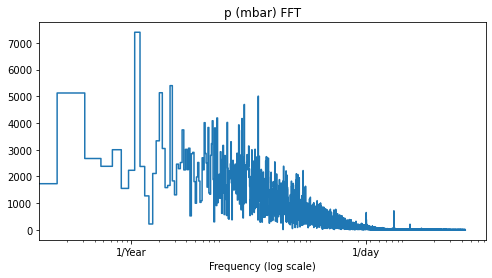

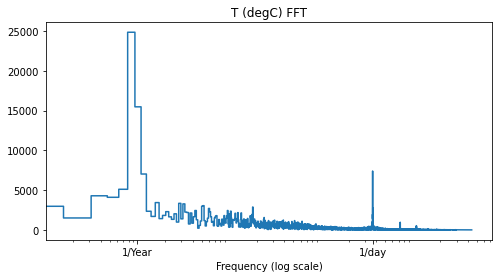

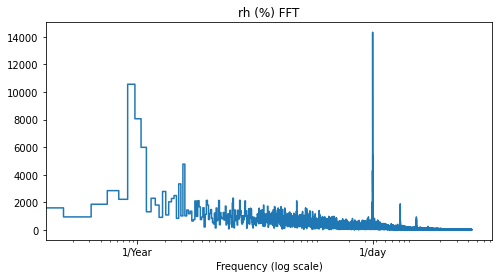

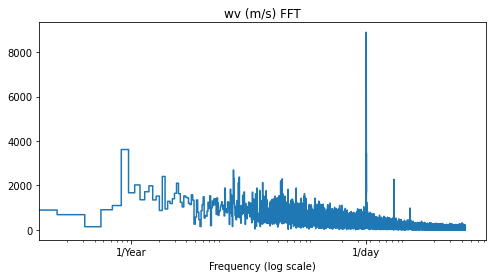

In [ ]:
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4] # change figure [width, height]
# for df_index, row in train_df.iteritems():
for df_index in ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']:  # plot only the 4 features for the report
  fft = scipy.fft.rfft(train_df[df_index].to_numpy())
  f_per_dataset = np.arange(0, len(fft))
  n_samples_h = len(train_df[df_index])
  hours_per_year = 24*365.2524
  years_per_dataset = n_samples_h/(hours_per_year)
  f_per_year = f_per_dataset/years_per_dataset

  fig, fftax = plt.subplots()
  fftax.step(f_per_year, np.abs(fft))
  fftax.set_xscale('log')
  fftax.set_xlim([0.1, max(plt.xlim())])
  plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
  fftax.set_xlabel('Frequency (log scale)')
  fftax.set_title(df_index + ' FFT')

plt.show()

Autocorrelation & Partial Autocorrelation

The autocorrelation of a time series describes the correlation between the lag between time points.

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

It is important to remove high autocorrelation to make the process more stationary (constant mean and variance)
this can be fixed by taking the first difference to make the mean zero throughout all time

data_diff = data[t] - data[t-1]

This first order difference is like a high pass filter to remove DC component

It might be good to then use only features with predictable periodicity autocorrelation

note: the auto correlation of white noise is an impulse function at zero

Basically means any feature similar to white noise is like using unpredictable random data as a feature

Features that do not resemble white noise after taking first difference
 - p (mbar)
 - T (degC)
 - Tpot (K)
 - rh (%)
 - VPmax (mbar)
 - VPdef (mbar)
 - rho (g/m**3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


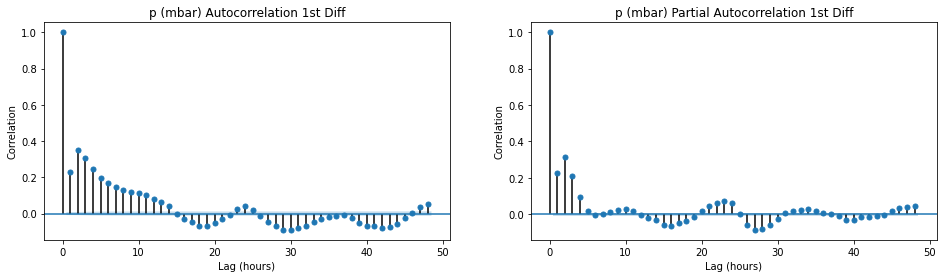

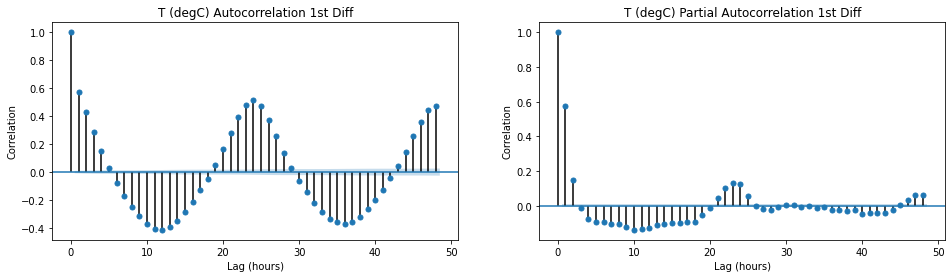

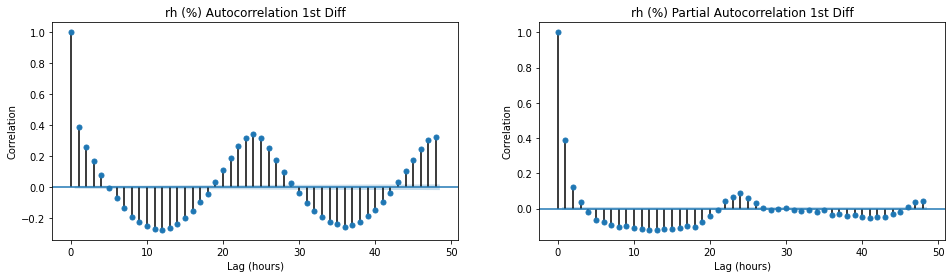

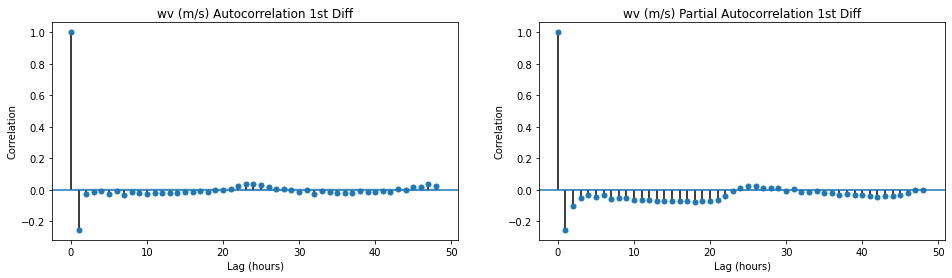

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize'] = [16, 4] # change figure [width, height]
# for df_index, row in train_df.iteritems():
for df_index in ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']:  # plot only the 4 features for report
  # figa, (autoax, pautoax) = plt.subplots(1, 2)
  # plot_acf(train_df[df_index], ax=autoax)
  # autoax.set_title(df_index + ' Autocorrelation')
  # autoax.set_xlabel('Lag (hours)')
  # autoax.set_ylabel('Correlation')
  # plot_pacf(train_df[df_index], ax=pautoax)
  # pautoax.set_title(df_index + ' Partial Autocorrelation')
  # pautoax.set_xlabel('Lag (hours)')
  # pautoax.set_ylabel('Correlation')

  diff = train_df[df_index].to_numpy()[0:-2] - train_df[df_index].to_numpy()[1:-1]

  figafd, (autofdax, pautofdax) = plt.subplots(1, 2)
  plot_acf(diff, ax=autofdax)
  autofdax.set_title(df_index + ' Autocorrelation 1st Diff')
  autofdax.set_xlabel('Lag (hours)')
  autofdax.set_ylabel('Correlation')
  plot_pacf(diff, ax=pautofdax)
  pautofdax.set_title(df_index + ' Partial Autocorrelation 1st Diff')
  pautofdax.set_xlabel('Lag (hours)')
  pautofdax.set_ylabel('Correlation')

plt.show()

Pearson Correlation Matrix between each feature

The Pearson correlation measures how two continuous signals co-vary over time and indicate the linear relationship as a number between -1 (negatively correlated) to 0 (not correlated) to 1 (perfectly correlated).

Features correlated with:

p(mbar):
- rho(g/m**3) = 0.34 (highest correlated feature)

T (degC):
- Tpot (K) = 1 because its just temp in Kelvin
- rh (%) = 0.83
- VPmax (mbar) = 0.92
- VPdef (mbar) = 0.82
- rho (g/m**3) = 0.99

rh (%):
- T (degC) = 0.83
- Tpot (K) = 0.82
- VPmax (mbar) = 0.77
- VPdef (mbar) = 0.86
- rho (g/m**3) = 0.78

wv (m/s):
- max. wv (m/s) = 0.88

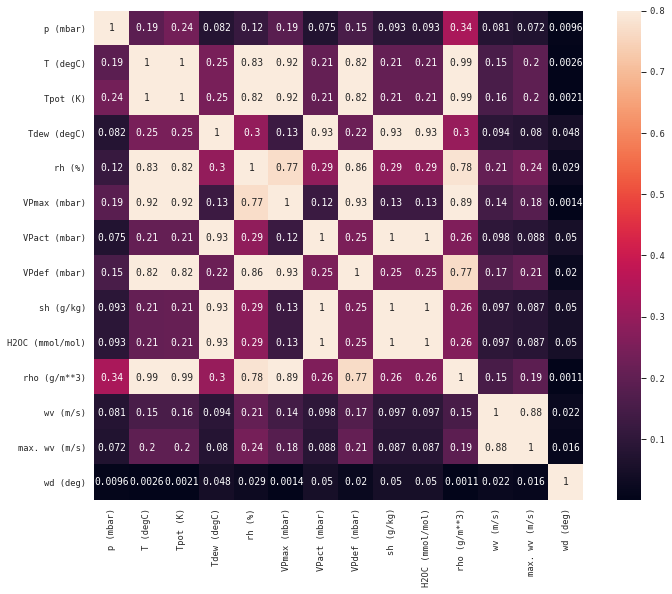

In [ ]:
import seaborn as sns
train_df_diff = train_df.copy()
# take difference between frames to maintain relatively stationary data (constant zero mean)
for df_index, row in train_df.iteritems():
  train_df_diff[df_index] = (train_df[df_index]-train_df[df_index].shift()).fillna(0)
corrmat = train_df_diff.corr(method='pearson', min_periods=1000)
# plot absolute values
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

# Sliding Window

In [ ]:
def Sliding_windows(data, seq_length, feature_columns = None, label_columns=None):
  """ takies data and seq_length (k) to produce feature and label with interest_columns """

  feature = []
  label = []

  ## select attributes in feature_columns we are interested in for training
  if feature_columns is not None:
    data_feature = data[feature_columns]
  else: data_feature = data

  ## select attributes in label_columns we are interested in for predicting
  if label_columns is not None:
      data_label = data[label_columns]
  else: data_label = data

  for i in range(len(data)-seq_length-1):

    feature_element = data_feature.iloc[i:(i+seq_length),:]
    label_element = data_label.iloc[(i+seq_length),:]

    feature.append(feature_element)
    label.append(label_element)

  feature = torch.Tensor(np.array(feature)).to(device)
  label = torch.Tensor(np.array(label)).to(device)

  return feature, label



In [ ]:
# create train feature and label
## TBD which feature feed into model
# feature_columns = ['p (mbar)','T (degC)','rh (%)','wv (m/s)']
p_features = ['p (mbar)', 'T (degC)', 'VPmax (mbar)', 'rho (g/m**3)']
T_features = ['T (degC)', 'rh (%)', 'VPmax (mbar)', 'VPdef (mbar)', 'rho (g/m**3)']
rh_features = ['rh (%)', 'T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'rho (g/m**3)']
wv_features = ['wv (m/s)', 'max. wv (m/s)', 'rh (%)']

feature_columns = list(set().union(p_features, T_features, rh_features, wv_features))
print('Input features:', feature_columns)

label_columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
print('Labels:', label_columns)

k = 4
batch_size = 32

# create training feature and label
train_feature, train_label = Sliding_windows(train_df, seq_length=k, feature_columns = feature_columns, label_columns=label_columns)
train_feature = DataLoader(train_feature, batch_size=batch_size, shuffle=False, drop_last= True)
train_label = DataLoader(train_label, batch_size=batch_size, shuffle=False, drop_last= True)

# create test feature and label
test_feature, test_label = Sliding_windows(test_df, seq_length=k, feature_columns = feature_columns, label_columns=label_columns)
test_feature = DataLoader(test_feature, batch_size=batch_size, shuffle=False, drop_last= True)
test_label = DataLoader(test_label, batch_size=batch_size, shuffle=False, drop_last= True)

Input features: ['p (mbar)', 'VPdef (mbar)', 'VPmax (mbar)', 'rh (%)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'T (degC)']
Labels: ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']


# Error propagation

In [ ]:
test_feature_data =  torch.Tensor(np.array(test_df[feature_columns])).to(device)
test_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)
test_pred_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)

def Error_propatation (model, time, k):
  loss_EP = []
  Time_EP = []
  model.eval()

  with torch.no_grad():
    for t in range(time, time+k+1):

      # Pick feature with from t-k to t with size (k * feature_number)
      feature_EP = test_feature_data[t-k:t]

      # model input should be (batch_size, k ,feature_number) 
      # Therefore, reshape to size with (batch_size = 1, k ,feature_number) 
      feature_EP = torch.unsqueeze(feature_EP, dim = 0)

      # get label with size (feature_number)
      label_EP = test_label_data[t,:]

      # get prediction
      predict_EP = model(feature_EP)

      # Update Feature: Replace true label at time t with predict value to achieve error propagation
      test_pred_label_data[t,:] = predict_EP

      loss = criterion(predict_EP, label_EP)

      print (f"@ Time step :{t}, Predict value: {predict_EP}, True Label:{label_EP}")

      loss_EP.append(loss.item())
      Time_EP.append(t)


  return loss_EP, Time_EP

# Train/Test function

In [ ]:
# training 
def Training(model, train_feature= train_feature, train_label = train_label):
  # start training
  model.train()  
  epoch_train_loss = 0
  for train_feature_batch, train_label_batch in zip(train_feature, train_label):we pu
    outputs = model(train_feature_batch)
    optimizer.zero_grad()

    # if not Error propagation, squeezing from size (batch_size, 1, k) to (batch_size, k) 
    # train_label_batch = torch.squeeze(train_label_batch)

    # obtain the loss function
    loss = criterion(outputs, train_label_batch)
    loss.backward()
    optimizer.step()
    epoch_train_loss += loss.item()
  return epoch_train_loss/ len(train_feature)
  

In [ ]:
# testing
def Testing(model, test_feature = test_feature, test_label = test_label):
  # start testing
  model.eval()
  epoch_test_loss = 0
  predict = []
  label = []
  with torch.no_grad():
    for test_feature_batch, test_label_batch in zip(test_feature, test_label):
      test_predict = model(test_feature_batch)

      # if not Error propagation, squeezing from size (batch_size, 1, k) to (batch_size, k) 
      # test_label_batch = torch.squeeze(test_label_batch)
      
      # obtain the loss function
      loss = criterion(test_predict, test_label_batch)
      predict.append(test_predict)
      label.append(test_label_batch)
      epoch_test_loss += loss.item()
  return epoch_test_loss / len(test_feature), predict, label


# Baseline: 3 layer dense NNs


## model

In [ ]:
class DENSENET(nn.Module):
  def __init__(self, input_size, hidden_sizes, num_classes):
    super(DENSENET, self).__init__()

    self.hidden1 = nn.Linear(input_size, hidden_sizes[0])
    self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
    self.hidden3 = nn.Linear(hidden_sizes[1], num_classes)
    
  def forward(self, data):
    x = F.relu(self.hidden1(data))
    x = F.relu(self.hidden2(x))
    output = self.hidden3(x) 
    # print (output.shape)

    # output size : batch_size * k * feature columns 

    return torch.squeeze(output[:,-1,:], dim =0)

    # torch.squeeze(output[:,-1,:], dim =0) size: batch size * feature columns 
    # target : batch size * feature columns 



## training + testing

In [ ]:
num_epochs = 10
learning_rate = 1e-4

input_size = len(feature_columns) # (N=14 for None)
hidden_sizes = [50,25]
num_classes = len(label_columns) # (N=14 for None)
batch_size = 32

# called 3 Dense layer, move to GPU
DenseNet = DENSENET(input_size, hidden_sizes, num_classes).to(device)
print (DenseNet)

summary(DenseNet,(4, 8), batch_size)

# Loss criterion
criterion = nn.MSELoss().to(device)

# optimizer
optimizer = torch.optim.Adam(DenseNet.parameters(), lr=learning_rate)

# scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Train/test the model
for epoch in range(num_epochs):

  ## training
  train_loss = Training (model=DenseNet, train_feature = train_feature, train_label = train_label)

  ## testing
  test_loss, predict, label = Testing (model=DenseNet, test_feature = test_feature, test_label = test_label)

  # Decay learning rate if needed.
  scheduler.step()

  print("Epoch: %d, train loss: %1.5f test loss: %1.5f" % (epoch+1, train_loss, test_loss))


DENSENET(
  (hidden1): Linear(in_features=8, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=25, bias=True)
  (hidden3): Linear(in_features=25, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [32, 4, 50]             450
            Linear-2                [32, 4, 25]           1,275
            Linear-3                 [32, 4, 4]             104
Total params: 1,829
Trainable params: 1,829
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.01
Estimated Total Size (MB): 0.09
----------------------------------------------------------------
Epoch: 1, train loss: 0.64988 test loss: 0.27672
Epoch: 2, train loss: 0.19048 test loss: 0.13217
Epoch: 3, train loss: 0.12533 test loss: 0.11411
Epoch: 4, train l

## Plot diagram

In [ ]:
##### processing predict #######

# flat predict list
predcit_flat = []
for sublist in predict:
  for item in sublist:
    predcit_flat.append(item)
print(len(predcit_flat))

# feature_columns = ['p (mbar)','T (degC)','rh (%)','wv (m/s)']
predict_p = []
predict_T = []
predict_rh = []
predict_wv = []

# store each feature
for i in range (len(predcit_flat)):
    predict_p.append (predcit_flat[i][0].cpu().data.numpy())
    predict_T.append (predcit_flat[i][1].cpu().data.numpy())
    predict_rh.append (predcit_flat[i][2].cpu().data.numpy())
    predict_wv.append (predcit_flat[i][3].cpu().data.numpy())


##### processing label #######

# flat label list
label_flat = []
for sublist in label:
  for item in sublist:
    label_flat.append(item)

print (len(label_flat))

label_p = []
label_T = []
label_rh = []
label_wv = []

# store each feature
for i in range (len(label_flat)):
    label_p.append (label_flat[i][0])
    label_T.append (label_flat[i][1])
    label_rh.append (label_flat[i][2])
    label_wv.append (label_flat[i][3])

# create array
predict_p = np.asfarray(predict_p,float).reshape(len(predict_p),1)
label_p = np.asfarray(label_p,float).reshape(len(label_p),1) 
predict_T = np.asfarray(predict_T,float).reshape(len(predict_T),1)
label_T = np.asfarray(label_T,float).reshape(len(label_T),1) 
predict_rh = np.asfarray(predict_rh,float).reshape(len(predict_rh),1)
label_rh = np.asfarray(label_rh,float).reshape(len(label_rh),1) 
predict_wv = np.asfarray(predict_wv,float).reshape(len(predict_wv),1)
label_wv = np.asfarray(label_wv,float).reshape(len(label_wv),1) 

# reparameterize it 
predict_p = predict_p * weather_train_std[label_columns[0]] + weather_train_mean[label_columns[0]]
label_p = label_p * weather_train_std[label_columns[0]] + weather_train_mean[label_columns[0]]
predict_T = predict_T * weather_train_std[label_columns[1]] + weather_train_mean[label_columns[1]]
label_T = label_T * weather_train_std[label_columns[1]] + weather_train_mean[label_columns[1]]
predict_rh = predict_rh * weather_train_std[label_columns[2]] + weather_train_mean[label_columns[2]]
label_rh = label_rh * weather_train_std[label_columns[2]] + weather_train_mean[label_columns[2]]
predict_wv = predict_wv * weather_train_std[label_columns[3]] + weather_train_mean[label_columns[3]]
label_wv = label_wv * weather_train_std[label_columns[3]] + weather_train_mean[label_columns[3]]



13984
13984


p (mbar)
Dense layer: Total MSE = 0.3577180468899333


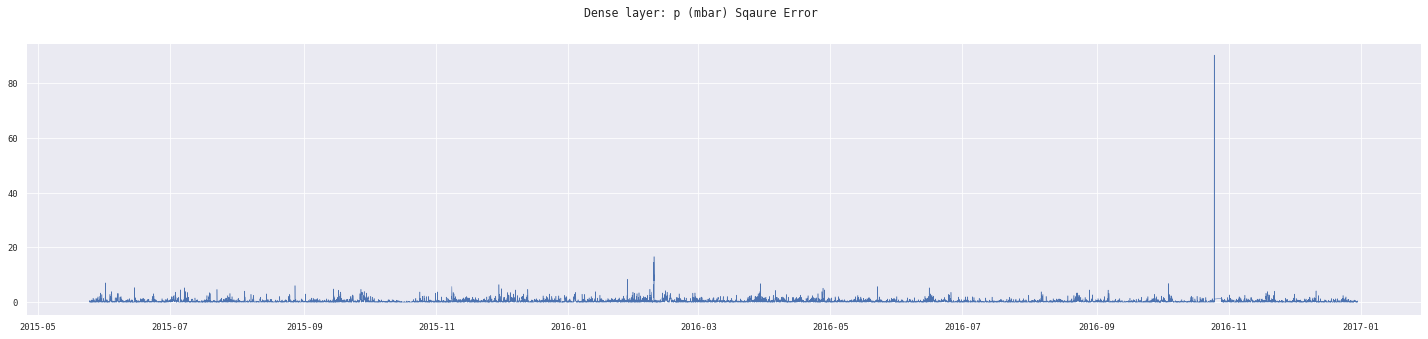

T (degC)
Dense layer: Total MSE = 1.1372678733858943


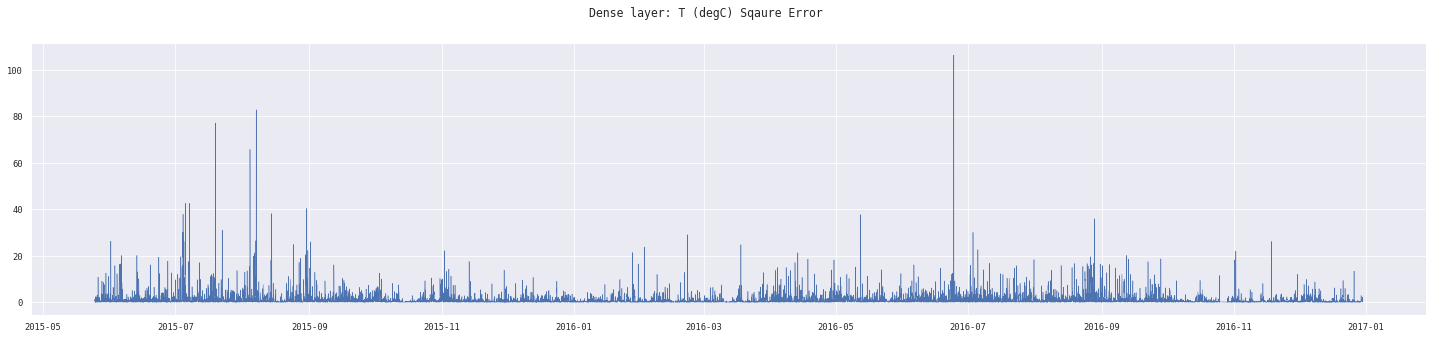

rh (%)
Dense layer: Total MSE = 20.37897046509785


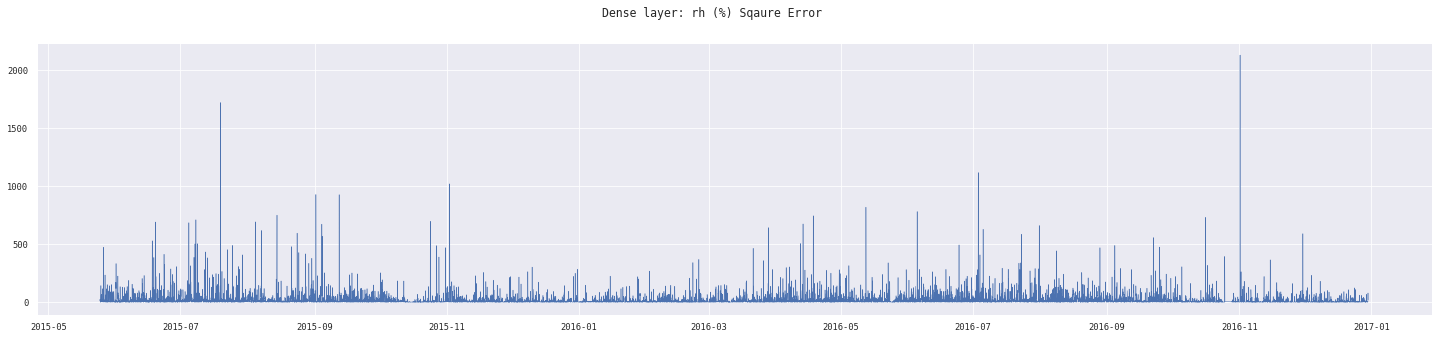

wv (m/s)
Dense layer: Total MSE = 0.8016784553194644


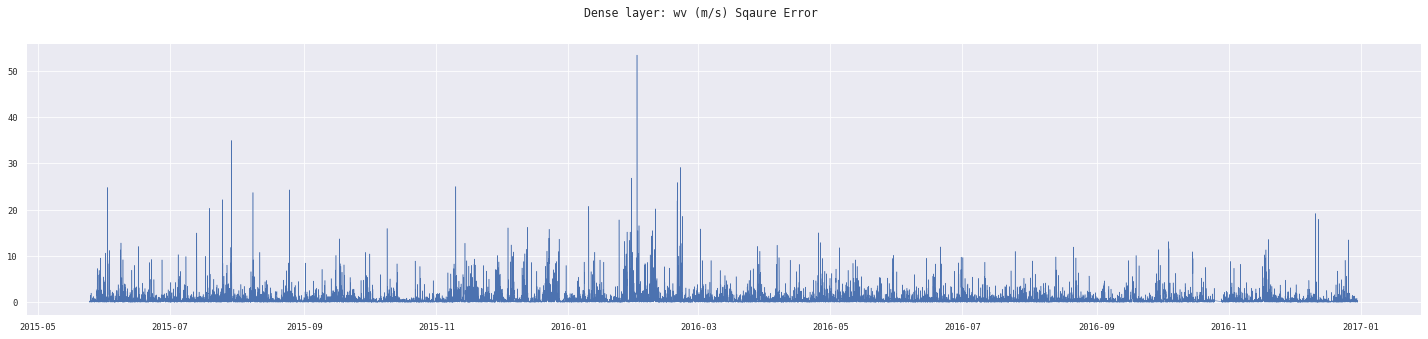

In [ ]:
# plot
for l in label_columns:
  if l == 'p (mbar)':
    se = np.square(label_p - predict_p)
  elif l == 'T (degC)':
    se = np.square(label_T - predict_T)
  elif l == 'rh (%)':
    se = np.square(label_rh - predict_rh)
  elif l == 'wv (m/s)':
    se = np.square(label_wv - predict_wv)
  print(l)
  print('Dense layer: Total MSE =', np.mean(se)) 

  # plot square error
  plt.figure(figsize=(25, 5))
  plt.plot(date_time_test[:len(label_p)], se, linewidth=0.5)
  plt.suptitle('Dense layer: ' + l + ' Sqaure Error')
  plt.show()
  # plt.savefig("Dense layer: " + l + " Sqaure Error.pdf", bbox_inches="tight", pad_inches=0)


  # Plot time series prediction
  # plt.figure(figsize=(25, 5))
  # plt.plot(date_time_test[:len(label_p)], predict_p, label="Prediction", linewidth=0.5)
  # plt.plot(date_time_test[:len(label_p)], label_p, label="True label", linewidth=0.5)
  # plt.legend(loc="upper left")
  # plt.suptitle('Dense layer: ' + l + ' Time-Series Prediction vs True label')
  # plt.show()
  # plt.savefig("Dense layer: " + l + " Time-Series Prediction vs True label.pdf", bbox_inches="tight", pad_inches=0)

## Error propagation 

@ Time step :4773, Predict value: tensor([ 2.2482, -0.1659,  0.0129, -0.2940], device='cuda:0'), True Label:tensor([ 2.4008, -0.2687, -0.0914, -0.4668], device='cuda:0')
@ Time step :4774, Predict value: tensor([ 2.3567, -0.2738, -0.0700, -0.3929], device='cuda:0'), True Label:tensor([ 2.4738, -0.2592, -0.1460, -0.3436], device='cuda:0')
@ Time step :4775, Predict value: tensor([ 2.4432, -0.2506, -0.1217, -0.3517], device='cuda:0'), True Label:tensor([ 2.5517, -0.3492, -0.1096,  0.0066], device='cuda:0')
@ Time step :4776, Predict value: tensor([ 2.5806, -0.3070, -0.1018, -0.1430], device='cuda:0'), True Label:tensor([ 2.5840, -0.4866,  0.2177,  0.0585], device='cuda:0')
@ Time step :4777, Predict value: tensor([ 2.6431, -0.4500,  0.2151, -0.2323], device='cuda:0'), True Label:tensor([ 2.6439, -0.5281,  0.2965,  0.2919], device='cuda:0')
Error Propagation MSE: 0.03545802030712366


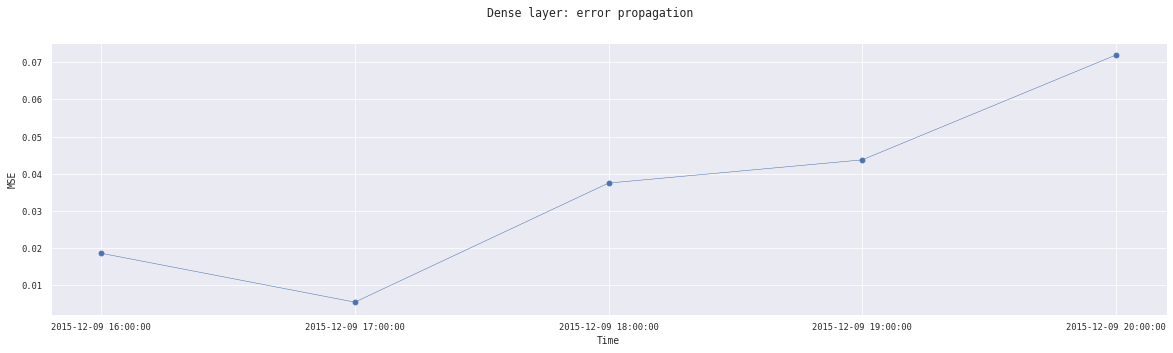

<Figure size 1152x288 with 0 Axes>

In [ ]:
## Used for test for all
time = 4773

## generate time 
# time = random.randrange(0,len(test_df)-1)

# Feed model into Error propagation function
loss_EP, Time_EP = Error_propatation(DenseNet,time, k =k)

print('Error Propagation MSE:', np.mean(loss_EP))

# Date time
Data_time = []
for i in Time_EP: Data_time.append(date_time_test[i])

# plot 
plt.figure(figsize=(20, 5))

plt.suptitle('Dense layer: error propagation')
plt.plot(Data_time, loss_EP, 'bo-' ,linewidth=0.5)
plt.xticks(Data_time)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))

plt.xlabel("Time")
plt.ylabel("MSE")

plt.show()
plt.savefig("Dense layer: error propagation.pdf", bbox_inches="tight", pad_inches=0)



# Baseline: RNNs(LSTM)

## model

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, num_layers, batch_size):
    super(LSTM, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.batch_size = batch_size

    ## LSTM
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, batch_first=True, dropout = 0.5).to(device)
    
    ## FC
    self.fc = nn.Linear(hidden_size, num_classes).to(device)

  def forward(self, data):

    ## move to device
    self.h_0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
    ## move to device
    self.c_0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
  
    # Propagate input through LSTM
    out_lstm, (self.h_0, self.c_0) = self.lstm(data, (self.h_0, self.c_0))
    
    predict = self.fc(out_lstm)

    return torch.squeeze(predict[:,-1,:], dim =0)

## training + test

In [ ]:
num_epochs = 10
learning_rate = 1e-4

input_size = len(feature_columns) # (N=14 for None)
hidden_size = 128
num_layers = 2
num_classes = len(label_columns) # (N=14 for None)


# called LSTM, move to GPU
lstm = LSTM(input_size, hidden_size, num_classes, num_layers, batch_size)

# Loss criterion
criterion = nn.MSELoss().to(device)

# optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Train/test the model
for epoch in range(num_epochs):
  
  ## training
  train_loss = Training(model = lstm , train_feature = train_feature, train_label = train_label)
  ## testing
  test_loss, predict, label = Testing(model = lstm , test_feature = test_feature, test_label = test_label)

  # Decay learning rate if needed.
  scheduler.step()

  print("Epoch: %d, train loss: %1.5f test loss: %1.5f" % (epoch+1, train_loss, test_loss))


Epoch: 1, train loss: 0.38817 test loss: 0.15305
Epoch: 2, train loss: 0.14745 test loss: 0.11623
Epoch: 3, train loss: 0.12854 test loss: 0.10902
Epoch: 4, train loss: 0.12218 test loss: 0.10344
Epoch: 5, train loss: 0.11979 test loss: 0.10226
Epoch: 6, train loss: 0.11807 test loss: 0.10128
Epoch: 7, train loss: 0.11653 test loss: 0.09858
Epoch: 8, train loss: 0.11578 test loss: 0.09840
Epoch: 9, train loss: 0.11515 test loss: 0.09808
Epoch: 10, train loss: 0.11492 test loss: 0.09713


## Plot diagram

In [ ]:
##### processing predict #######

# flat predict list
predcit_flat = []
for sublist in predict:
  for item in sublist:
    predcit_flat.append(item)
print(len(predcit_flat))

# feature_columns = ['p (mbar)','T (degC)','rh (%)','wv (m/s)']
predict_p = []
predict_T = []
predict_rh = []
predict_wv = []

# store each feature
for i in range (len(predcit_flat)):
    predict_p.append (predcit_flat[i][0].cpu().data.numpy())
    predict_T.append (predcit_flat[i][1].cpu().data.numpy())
    predict_rh.append (predcit_flat[i][2].cpu().data.numpy())
    predict_wv.append (predcit_flat[i][3].cpu().data.numpy())


##### processing label #######

# flat label list
label_flat = []
for sublist in label:
  for item in sublist:
    label_flat.append(item)

print (len(label_flat))

label_p = []
label_T = []
label_rh = []
label_wv = []

# store each feature
for i in range (len(label_flat)):
    label_p.append (label_flat[i][0])
    label_T.append (label_flat[i][1])
    label_rh.append (label_flat[i][2])
    label_wv.append (label_flat[i][3])

# create array
predict_p = np.asfarray(predict_p,float).reshape(len(predict_p),1)
label_p = np.asfarray(label_p,float).reshape(len(label_p),1) 
predict_T = np.asfarray(predict_T,float).reshape(len(predict_T),1)
label_T = np.asfarray(label_T,float).reshape(len(label_T),1) 
predict_rh = np.asfarray(predict_rh,float).reshape(len(predict_rh),1)
label_rh = np.asfarray(label_rh,float).reshape(len(label_rh),1) 
predict_wv = np.asfarray(predict_wv,float).reshape(len(predict_wv),1)
label_wv = np.asfarray(label_wv,float).reshape(len(label_wv),1) 

# reparameterize it 
predict_p = predict_p * weather_train_std[label_columns[0]] + weather_train_mean[label_columns[0]]
label_p = label_p * weather_train_std[label_columns[0]] + weather_train_mean[label_columns[0]]
predict_T = predict_T * weather_train_std[label_columns[1]] + weather_train_mean[label_columns[1]]
label_T = label_T * weather_train_std[label_columns[1]] + weather_train_mean[label_columns[1]]
predict_rh = predict_rh * weather_train_std[label_columns[2]] + weather_train_mean[label_columns[2]]
label_rh = label_rh * weather_train_std[label_columns[2]] + weather_train_mean[label_columns[2]]
predict_wv = predict_wv * weather_train_std[label_columns[3]] + weather_train_mean[label_columns[3]]
label_wv = label_wv * weather_train_std[label_columns[3]] + weather_train_mean[label_columns[3]]



13984
13984


p (mbar)
LSTM: Total MSE = 0.7363623673224335


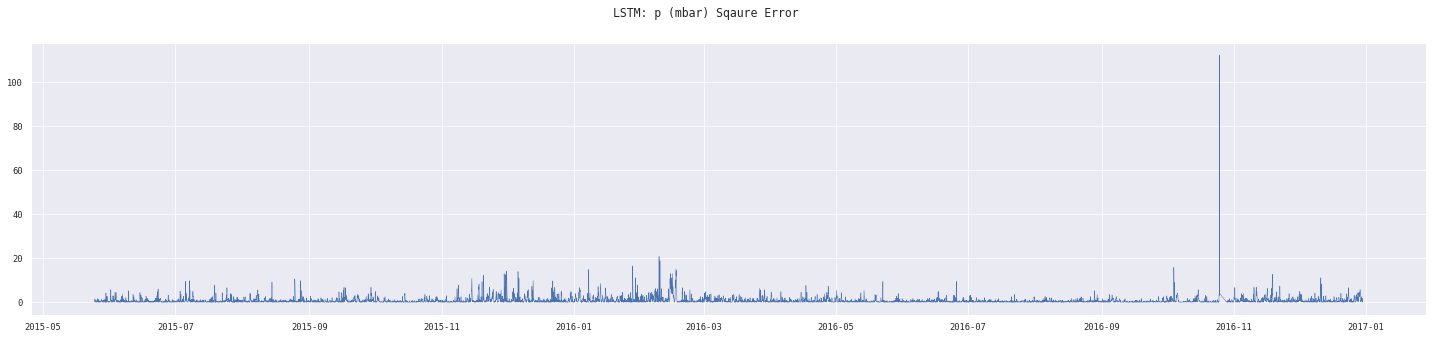

T (degC)
LSTM: Total MSE = 1.059427866737992


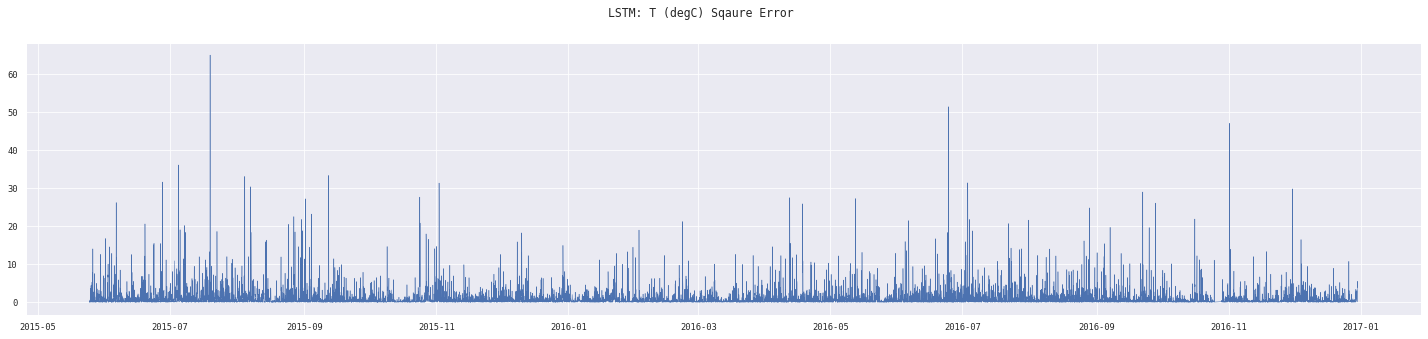

rh (%)
LSTM: Total MSE = 14.807250053090984


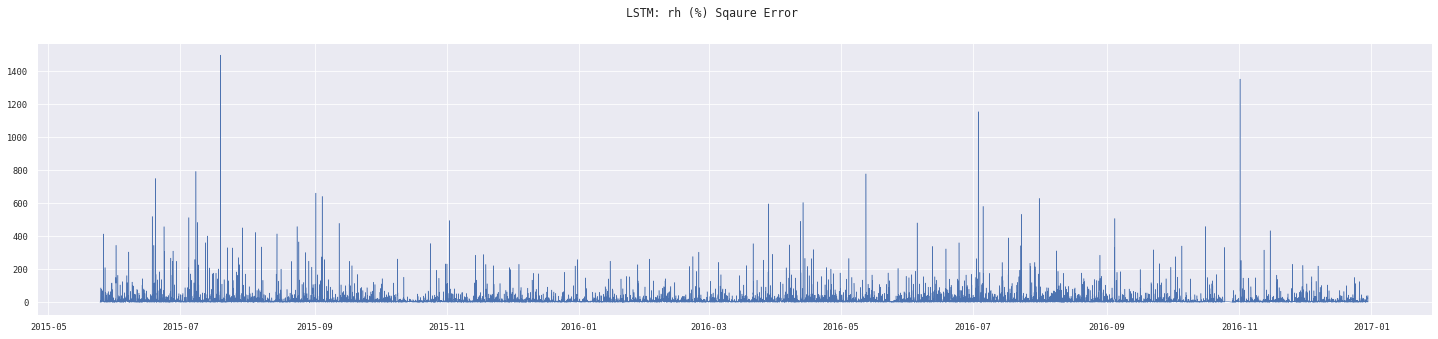

wv (m/s)
LSTM: Total MSE = 0.7334012138354836


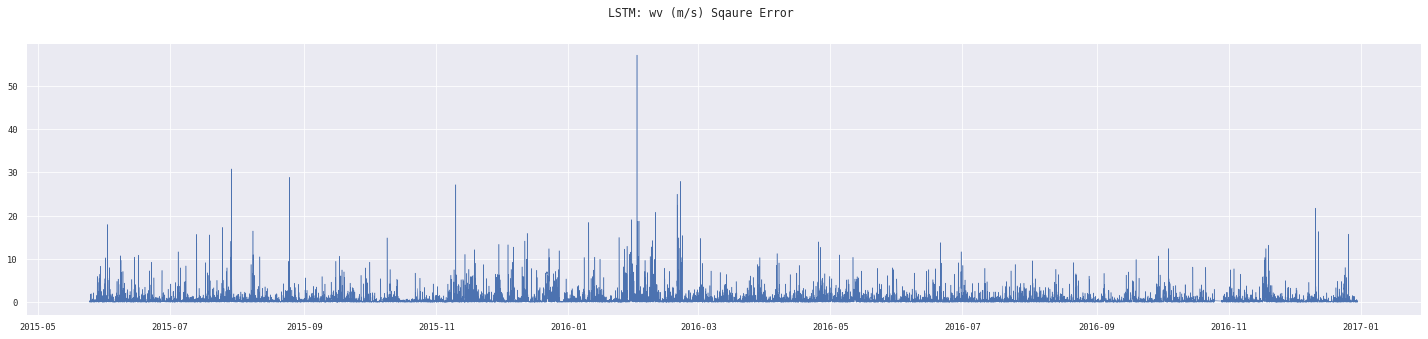

In [ ]:
# plot
for l in label_columns:
  if l == 'p (mbar)':
    se = np.square(label_p - predict_p)
  elif l == 'T (degC)':
    se = np.square(label_T - predict_T)
  elif l == 'rh (%)':
    se = np.square(label_rh - predict_rh)
  elif l == 'wv (m/s)':
    se = np.square(label_wv - predict_wv)
  print(l)
  print('LSTM: Total MSE =', np.mean(se))

  plt.figure(figsize=(25, 5))
  plt.plot(date_time_test[:len(label_p)], se, linewidth=0.5)
  plt.suptitle('LSTM: ' + l + ' Sqaure Error')
  plt.show()
  # plt.savefig("LSTM: " + l + " Sqaure Error.pdf", bbox_inches="tight", pad_inches=0)

  # plt.figure(figsize=(25, 5))
  # plt.plot(date_time_test[:len(label_p)], predict_p, label="Prediction", linewidth=0.5)
  # plt.plot(date_time_test[:len(label_p)], label_p, label="True label", linewidth=0.5)
  # plt.legend(loc="upper left")
  # plt.suptitle('LSTM: ' + predict_feat + ' Time-Series Prediction vs True label')
  # plt.show()
  # plt.savefig("LSTM: " + predict_feat + " Time-Series Prediction vs True label.pdf", bbox_inches="tight", pad_inches=0)


## Error propagation 

tensor([ 2.2016,  0.0431, -0.0757, -0.2998], device='cuda:0')
@ Time step :4773, Predict value: tensor([ 2.2016,  0.0431, -0.0757, -0.2998], device='cuda:0'), True Label:tensor([ 2.4008, -0.2687, -0.0914, -0.4668], device='cuda:0')
tensor([ 2.2670, -0.0798, -0.0282, -0.4649], device='cuda:0')
@ Time step :4774, Predict value: tensor([ 2.2670, -0.0798, -0.0282, -0.4649], device='cuda:0'), True Label:tensor([ 2.4738, -0.2592, -0.1460, -0.3436], device='cuda:0')
tensor([ 2.3504, -0.1541, -0.0877, -0.4714], device='cuda:0')
@ Time step :4775, Predict value: tensor([ 2.3504, -0.1541, -0.0877, -0.4714], device='cuda:0'), True Label:tensor([ 2.5517, -0.3492, -0.1096,  0.0066], device='cuda:0')
tensor([ 2.4400, -0.2833, -0.0331, -0.3315], device='cuda:0')
@ Time step :4776, Predict value: tensor([ 2.4400, -0.2833, -0.0331, -0.3315], device='cuda:0'), True Label:tensor([ 2.5840, -0.4866,  0.2177,  0.0585], device='cuda:0')
tensor([ 2.5098, -0.5112,  0.3417, -0.3882], device='cuda:0')
@ Time ste

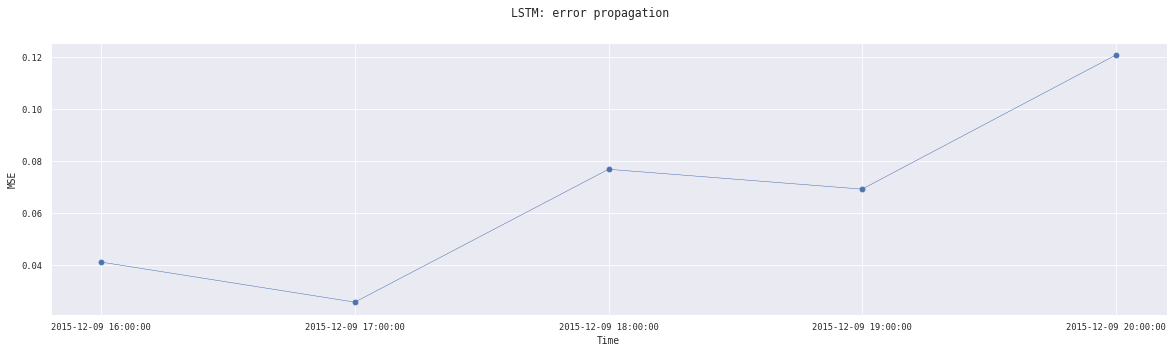

<Figure size 1152x288 with 0 Axes>

In [ ]:
## Used for test for all
time = 4773

## generate time 
# time = random.randrange(0,len(test_df)-1)

loss_EP = []
Time_EP = []

with torch.no_grad():
  for t in range(time, time+k+1):

    # Pick feature with from t-k to t with size (k * feature_number)
    feature_EP = test_feature_data[t-k:t]

    # model input should be (batch_size, k ,feature_number) 
    # LSTM need batch_size = 32

    # First, reshape to size with (batch_size = 1, k ,feature_number) 
    feature_EP = torch.unsqueeze(feature_EP, dim = 0)
    # Then, cat to (batch_size = 32, k ,feature_number) 
    for i in range(int(math.log(batch_size, 2))):
      feature_EP = torch.cat((feature_EP, feature_EP), 0)

    # get label with size (feature_number)
    label_EP = test_label_data[t,:]

    # get prediction
    predict_EP = lstm(feature_EP)

    print(predict_EP[0])

    # Update Feature: Replace true label at time t with predict value to achieve error propagation
    test_pred_label_data[t,:] = predict_EP[0]

    loss = criterion(predict_EP[0], label_EP)

    print (f"@ Time step :{t}, Predict value: {predict_EP[0]}, True Label:{label_EP}")

    loss_EP.append(loss.item())
    Time_EP.append(t)

print('Error Propagation MSE:', np.mean(loss_EP))

# Date time
Data_time = []
for i in Time_EP: Data_time.append(date_time_test[i])

# plot 
plt.figure(figsize=(20, 5))

plt.suptitle('LSTM: error propagation')
plt.plot(Data_time, loss_EP, 'bo-' ,linewidth=0.5)
plt.xticks(Data_time)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))

plt.xlabel("Time")
plt.ylabel("MSE")

plt.show()
plt.savefig("LSTM model: error propagation.pdf", bbox_inches="tight", pad_inches=0)


# Our model:
2 layer 1D CNN + 1 FCNN

## model

In [ ]:
class My_CNN(nn.Module):
  def __init__(self, input_size, hidden_sizes, num_classes):
    super(My_CNN, self).__init__()
    
    self.input_size = input_size
    self.hidden_sizes = hidden_sizes
    self.num_classes = num_classes
    
    self.conv1 = nn.Conv1d(self.input_size, self.hidden_sizes[0], kernel_size=3, padding=1)
    self.conv2 = nn.Conv1d(self.hidden_sizes[0], self.hidden_sizes[1], kernel_size=3, padding=1)
    self.fc1 = nn.Linear(self.hidden_sizes[1], self.num_classes)
    

  def forward(self, data):
    # input data size: batch * k * feature number -> batch * feature number * k 
    # Swap 
    data = torch.swapaxes(data, 1, 2)
    x = F.relu(self.conv1(data))
    x = F.relu(self.conv2(x))
    # x: batch * feature number * k -> batch * k * feature number
    # Swap back
    x = torch.swapaxes(x, 1, 2)
    output = self.fc1(x)
    return torch.squeeze(output[:,-1,:], dim =0)

## training + testing

In [ ]:
num_epochs = 10
learning_rate = 1e-4

input_size = len(feature_columns) # (N=14 for None)
hidden_sizes = [50,25]
num_classes = len(label_columns) # (N=14 for None)


# called LSTM, move to GPU
CNN = My_CNN(input_size, hidden_sizes, num_classes).to(device)
print (CNN)

summary(CNN,(4, 8), batch_size)

# Loss criterion
criterion = nn.MSELoss().to(device)

# optimizer
optimizer = torch.optim.Adam(CNN.parameters(), lr=learning_rate)

# scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Train/test the model
for epoch in range(num_epochs):
  
  ## training
  train_loss = Training(CNN, train_feature = train_feature, train_label = train_label)
  ## testing
  test_loss, predict, label = Testing(CNN, test_feature = test_feature, test_label = test_label)
  # Decay learning rate if needed.
  scheduler.step()

  print("Epoch: %d, train loss: %1.5f test loss: %1.5f" % (epoch+1, train_loss, test_loss))


My_CNN(
  (conv1): Conv1d(8, 50, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(50, 25, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=25, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [32, 50, 4]           1,250
            Conv1d-2                [32, 25, 4]           3,775
            Linear-3                 [32, 4, 4]             104
Total params: 5,129
Trainable params: 5,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.02
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
Epoch: 1, train loss: 0.44283 test loss: 0.16412
Epoch: 2, train loss: 0.12935 test loss: 0.10851
Epoch: 3, train loss: 0.10940 test loss: 0.10363
Epoch: 4,

## Plot diagram

In [ ]:
##### processing predict #######

# flat predict list
predcit_flat = []
for sublist in predict:
  for item in sublist:
    predcit_flat.append(item)
print(len(predcit_flat))

# feature_columns = ['p (mbar)','T (degC)','rh (%)','wv (m/s)']
predict_p = []
predict_T = []
predict_rh = []
predict_wv = []

# store each feature
for i in range (len(predcit_flat)):
    predict_p.append (predcit_flat[i][0].cpu().data.numpy())
    predict_T.append (predcit_flat[i][1].cpu().data.numpy())
    predict_rh.append (predcit_flat[i][2].cpu().data.numpy())
    predict_wv.append (predcit_flat[i][3].cpu().data.numpy())


##### processing label #######

# flat label list
label_flat = []
for sublist in label:
  for item in sublist:
    label_flat.append(item)

print (len(label_flat))

label_p = []
label_T = []
label_rh = []
label_wv = []

# store each feature
for i in range (len(label_flat)):
    label_p.append (label_flat[i][0])
    label_T.append (label_flat[i][1])
    label_rh.append (label_flat[i][2])
    label_wv.append (label_flat[i][3])

# create array
predict_p = np.asfarray(predict_p,float).reshape(len(predict_p),1)
label_p = np.asfarray(label_p,float).reshape(len(label_p),1) 
predict_T = np.asfarray(predict_T,float).reshape(len(predict_T),1)
label_T = np.asfarray(label_T,float).reshape(len(label_T),1) 
predict_rh = np.asfarray(predict_rh,float).reshape(len(predict_rh),1)
label_rh = np.asfarray(label_rh,float).reshape(len(label_rh),1) 
predict_wv = np.asfarray(predict_wv,float).reshape(len(predict_wv),1)
label_wv = np.asfarray(label_wv,float).reshape(len(label_wv),1) 

# reparameterize it 
predict_p = predict_p * weather_train_std[label_columns[0]] + weather_train_mean[label_columns[0]]
label_p = label_p * weather_train_std[label_columns[0]] + weather_train_mean[label_columns[0]]
predict_T = predict_T * weather_train_std[label_columns[1]] + weather_train_mean[label_columns[1]]
label_T = label_T * weather_train_std[label_columns[1]] + weather_train_mean[label_columns[1]]
predict_rh = predict_rh * weather_train_std[label_columns[2]] + weather_train_mean[label_columns[2]]
label_rh = label_rh * weather_train_std[label_columns[2]] + weather_train_mean[label_columns[2]]
predict_wv = predict_wv * weather_train_std[label_columns[3]] + weather_train_mean[label_columns[3]]
label_wv = label_wv * weather_train_std[label_columns[3]] + weather_train_mean[label_columns[3]]



13984
13984


p (mbar)
Our model: Total MSE = 0.4642551699126618


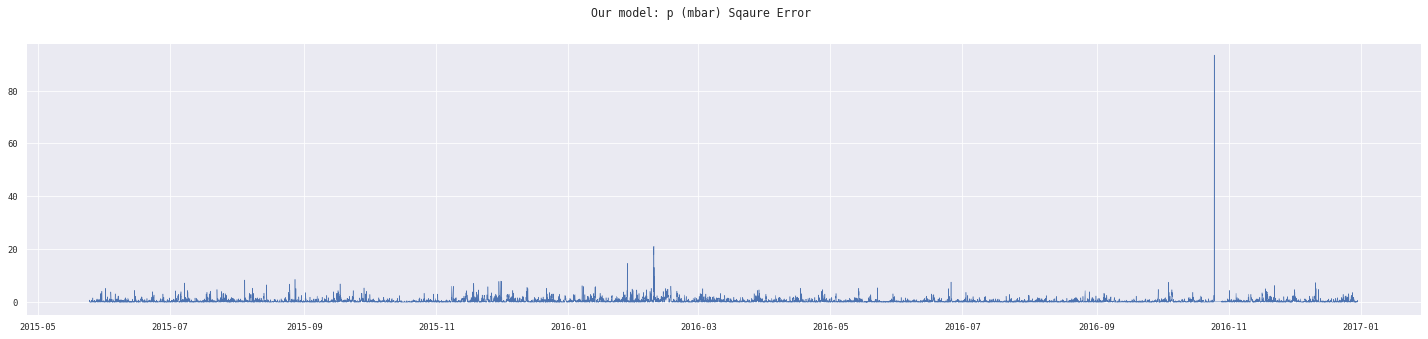

T (degC)
Our model: Total MSE = 0.8677980146235881


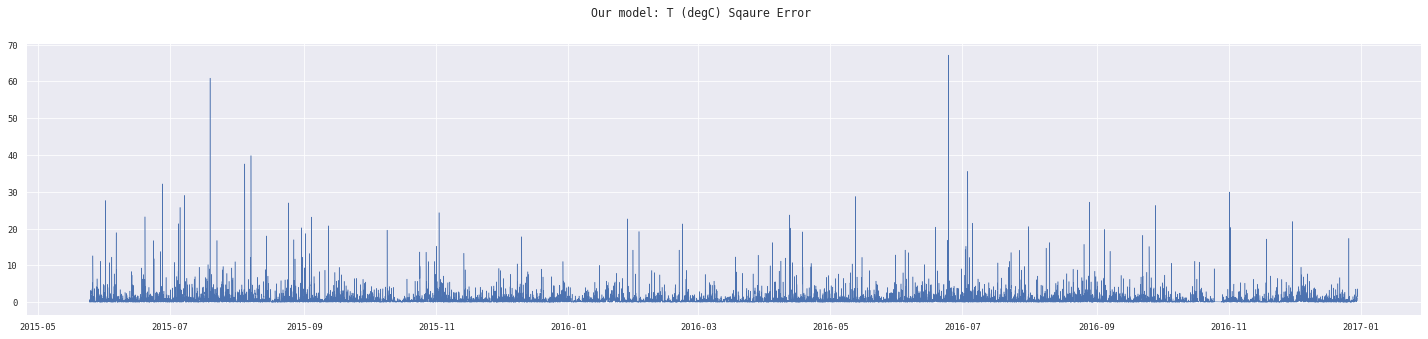

rh (%)
Our model: Total MSE = 15.385311517895618


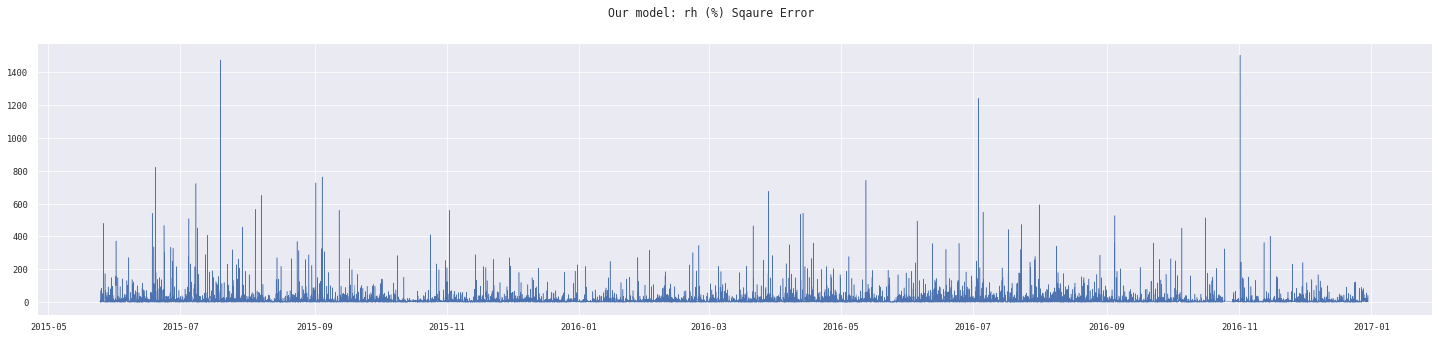

wv (m/s)
Our model: Total MSE = 0.7452877207108536


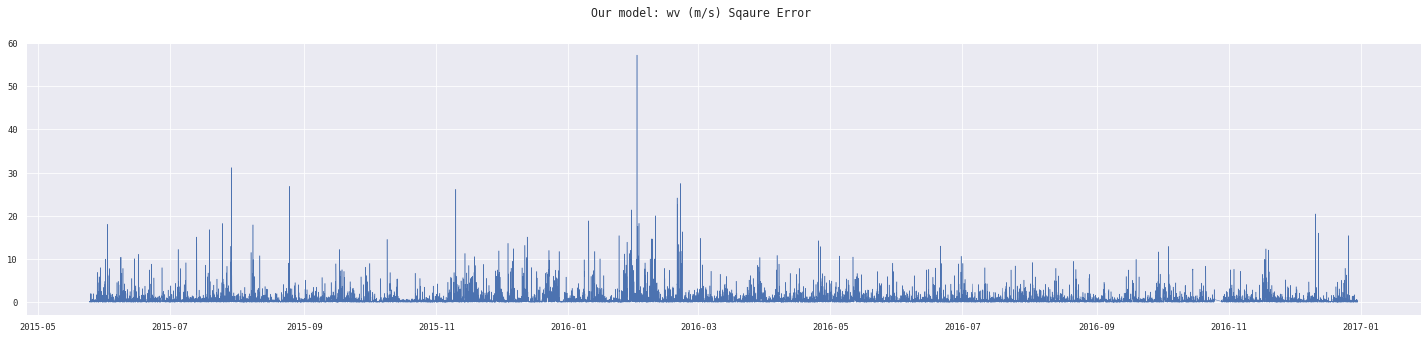

In [ ]:
# plot
for l in label_columns:
  if l == 'p (mbar)':
    se = np.square(label_p - predict_p)
  elif l == 'T (degC)':
    se = np.square(label_T - predict_T)
  elif l == 'rh (%)':
    se = np.square(label_rh - predict_rh)
  elif l == 'wv (m/s)':
    se = np.square(label_wv - predict_wv)

  print(l)
  print('Our model: Total MSE =', np.mean(se)) 

  plt.figure(figsize=(25, 5))
  plt.plot(date_time_test[:len(label_p)], se, linewidth=0.5)
  plt.suptitle('Our model: ' + l + ' Sqaure Error')
  plt.show()
  # plt.savefig("Our model: " + l + " Sqaure Error.pdf", bbox_inches="tight", pad_inches=0)
  # plt.figure(figsize=(25, 5))
  # plt.plot(date_time_test[:len(label_p)], predict_p, label="Prediction", linewidth=0.5)
  # plt.plot(date_time_test[:len(label_p)], label_p, label="True label", linewidth=0.5)
  # plt.legend(loc="upper left")
  # plt.suptitle('Our model: ' + predict_feat + ' Time-Series Prediction vs True label')
  # plt.show()
  # plt.savefig("Our model: " + predict_feat + " Time-Series Prediction vs True label.pdf", bbox_inches="tight", pad_inches=0)


## Error propagation 

@ Time step :4773, Predict value: tensor([ 2.2650, -0.0276, -0.1626, -0.2214], device='cuda:0'), True Label:tensor([ 2.4008, -0.2687, -0.0914, -0.4668], device='cuda:0')
@ Time step :4774, Predict value: tensor([ 2.3266, -0.1736, -0.1418, -0.4130], device='cuda:0'), True Label:tensor([ 2.4738, -0.2592, -0.1460, -0.3436], device='cuda:0')
@ Time step :4775, Predict value: tensor([ 2.3975, -0.2361, -0.1474, -0.4206], device='cuda:0'), True Label:tensor([ 2.5517, -0.3492, -0.1096,  0.0066], device='cuda:0')
@ Time step :4776, Predict value: tensor([ 2.4608, -0.3108, -0.0843, -0.2546], device='cuda:0'), True Label:tensor([ 2.5840, -0.4866,  0.2177,  0.0585], device='cuda:0')
@ Time step :4777, Predict value: tensor([ 2.5113, -0.4863,  0.2985, -0.3272], device='cuda:0'), True Label:tensor([ 2.6439, -0.5281,  0.2965,  0.2919], device='cuda:0')
Error Propagation MSE: 0.05170695818960667


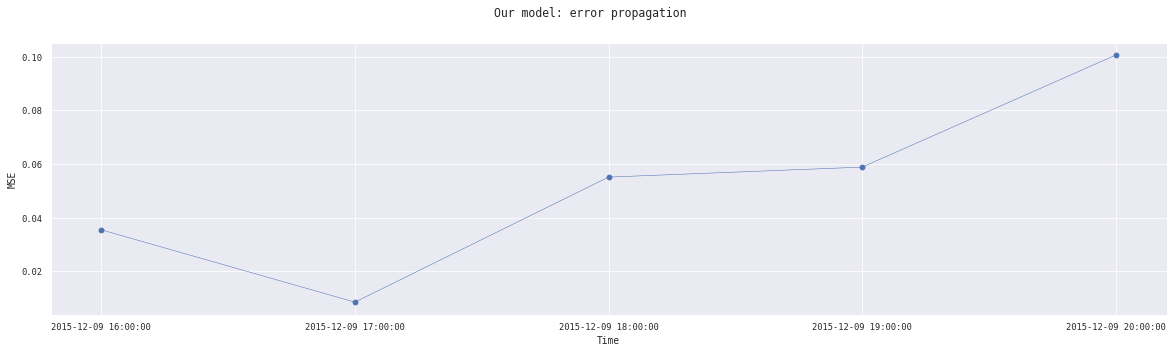

<Figure size 1152x288 with 0 Axes>

In [ ]:
## Used for test for all
time = 4773

## generate time 
# time = random.randrange(0,len(test_df)-1)

# Feed model into Error propagation function
loss_EP, Time_EP = Error_propatation(CNN,time,k=k)

print('Error Propagation MSE:', np.mean(loss_EP))

# Date time
Data_time = []
for i in Time_EP: Data_time.append(date_time_test[i])

# plot 
plt.figure(figsize=(20, 5))

plt.suptitle('Our model: error propagation')
plt.plot(Data_time, loss_EP, 'bo-' ,linewidth=0.5)
plt.xticks(Data_time)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))

plt.xlabel("Time")
plt.ylabel("MSE")

plt.show()
plt.savefig("Our model: error propagation.pdf", bbox_inches="tight", pad_inches=0)
